# Autoencoder: _Model SubclassingI_ with MNIST & TensorFlow 2

In [1]:
import tensorflow as tf
import tensorflow
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU, LeakyReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
import numpy as np


In [2]:
print(f"TF version: {tf.__version__}")

TF version: 2.7.0


In [3]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"GPU: {gpu_devices}")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: Tesla K80


#### Data preprocessing and cleaning:

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28

In [6]:
# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [8]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (28, 28, 1)


In [9]:
# Specify hyper-parameters-
batch_size = 60
num_classes = 10
num_epochs = 100

In [10]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks work best when each input is inside the range –1 to 1, so we need to divide by 255.

In [11]:
# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [12]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [13]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (60000, 28, 28, 1), y_train.shape: (60000, 10)
X_test.shape: (10000, 28, 28, 1), y_test.shape: (10000, 10)


### Define Autoencoder using _Model Subclassing_ & _Convolutional_ layers

In [14]:
# Specify latent space dimensions-
latent_space_dim = 3

In [15]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = Sequential(
            [
                InputLayer(input_shape = (28, 28, 1)),
                # Input(shape = (28, 28, 1)),
                Conv2D(
                    filters = 32, kernel_size = 3,
                    strides = 2, padding = 'same',
                    activation = tf.keras.layers.LeakyReLU(alpha = 0.3)
                ),
                Conv2D(
                    filters = 64, kernel_size = 3,
                    strides = 2, padding = 'same',
                    activation = tf.keras.layers.LeakyReLU(alpha = 0.3)
                ),
                Conv2D(
                    filters = 64, kernel_size = 3,
                    strides = 1, padding = 'same',
                    activation = tf.keras.layers.LeakyReLU(alpha = 0.3)
                ),
                Conv2D(
                    filters = 64, kernel_size = 3,
                    strides = 1, padding = 'same',
                    activation = tf.keras.layers.LeakyReLU(alpha = 0.3)
                ),
                Flatten(),
                Dense(
                    units = self.latent_dim,
                    activation = tf.keras.layers.LeakyReLU(alpha = 0.3)
                )
            ]
        )
        
        self.decoder = Sequential(
            [
                InputLayer(input_shape = self.latent_dim),
                # Input(shape = self.latent_dim),
                Dense(
                    units = 7 * 7 * 64,
                    activation = tf.keras.layers.LeakyReLU(alpha = 0.3)
                ),
                Reshape((7, 7, 64)),
                Conv2DTranspose(
                    filters = 64, kernel_size = (3, 3),
                    strides = (1, 1), padding = 'same',
                    activation = tf.keras.layers.LeakyReLU(alpha = 0.3)
                ),
                Conv2DTranspose(
                    filters = 64, kernel_size = (3, 3),
                    strides = (2, 2), padding = 'same',
                    activation = tf.keras.layers.LeakyReLU(alpha = 0.3)
                ),
                Conv2DTranspose(
                    filters = 32, kernel_size = (3, 3),
                    strides = (2, 2), padding = 'same',
                    activation = tf.keras.layers.LeakyReLU(alpha = 0.3)
                ),
                Conv2DTranspose(
                    filters = 1, kernel_size = (3, 3),
                    strides = (1, 1), padding = 'same',
                    activation = 'sigmoid'
                )
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    

In [16]:
# Initialize and build an instance of Autoencoder using conv layers-
model = Autoencoder(latent_dim = latent_space_dim)
model.build(input_shape = (None, 28, 28, 1))

In [17]:
# Print model summary-
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 3)                 102083    
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         105153    
                                                                 
Total params: 207,236
Trainable params: 207,236
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Manually count number of trainable parameters for each layer-
tot_params = 0
for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    print(f"layer: {layer.shape} has {loc_params} params")
    tot_params += loc_params

layer: (3, 3, 1, 32) has 288 params
layer: (32,) has 0 params
layer: (3, 3, 32, 64) has 18432 params
layer: (64,) has 0 params
layer: (3, 3, 64, 64) has 36864 params
layer: (64,) has 0 params
layer: (3, 3, 64, 64) has 36864 params
layer: (64,) has 0 params
layer: (3136, 3) has 9408 params
layer: (3,) has 0 params
layer: (3, 3136) has 9408 params
layer: (3136,) has 0 params
layer: (3, 3, 64, 64) has 36864 params
layer: (64,) has 0 params
layer: (3, 3, 64, 64) has 36864 params
layer: (64,) has 0 params
layer: (3, 3, 32, 64) has 18432 params
layer: (32,) has 0 params
layer: (3, 3, 1, 32) has 288 params
layer: (1,) has 0 params


In [19]:
print(f"Total number of trainable parameters = {tot_params}")

Total number of trainable parameters = 203712


In [ ]:
# Save randomly initialized weights-
model.save_weights(
    "Autoencoder_MNIST_Model_Subclassing_Initial_Weights.h5",
    overwrite = True
    )

In [ ]:
'''
# Load randomly initialized weights-
model.load_weights(
    "Autoencoder_MNIST_Model_Subclassing_Initial_Weights.h5"
)
'''

In [21]:
# Sanity check-
model(X_train[:2, :]).shape

TensorShape([2, 28, 28, 1])

In [22]:
# Sanity check-
encoder_output = model.encoder(X_train[:2, :])
print(f"For input shape = {model(X_train[:2, :]).shape}, "
      f"encoder output shape = {encoder_output.shape}"
     )

For input shape = (2, 28, 28, 1), encoder output shape = (2, 3)


In [23]:
# Sanity check-
decoder_output = model.decoder(encoder_output)
print(f"For encoder output shape = {encoder_output.shape}, "
      f"decoder output shape = {decoder_output.shape}"
     )

For encoder output shape = (2, 3), decoder output shape = (2, 28, 28, 1)


In [24]:
del encoder_output, decoder_output

#### Loss function

The loss function is usually chosen to be either-
1. root mean squared error (RMSE) or
1. binary cross-entropy

between the individual pixels of the original image and the reconstruction.

__Binary cross-entropy places heavier penalties on predictions at the extremes that are badly wrong, so it tends to push pixel predictions to the middle of the range. This results in less vibrant images__.

For this reason, author generally prefer to use RMSE as the loss function. However, there is no right or wrong choice — you should choose whichever works best for your use case.

In [ ]:
def RMSE_loss(y_true, y_pred):
    # RMSE loss function.
    return K.mean(K.square(y_true - y_pred), axis = [1, 2, 3])


In [ ]:
# Compile defined autoencoder model-
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003),
    # loss = RMSE_loss
    loss = tf.keras.losses.BinaryCrossentropy()
    )

In [ ]:
# Define early stopping criterion-
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', min_delta = 0.0001,
    patience = 4,
    restore_best_weights = True
)
# Adjust 'min_delta' according to training loss for early stopping
# to effectively happen.

In [ ]:
num_epochs = 200
print(f"number of training epochs = {num_epochs}")

number of training epochs = 200


In [ ]:
# Train autoencoder-
training_hist = model.fit(
    x = X_train, y = X_train,
    batch_size = batch_size, shuffle = True,
    validation_data = (X_test, X_test),
    epochs = num_epochs, callbacks = [early_stopping]
    )

Epoch 1/200
1000/1000 [==============================] - 94s 18ms/step - loss: 0.2366 - val_loss: 0.1968
Epoch 2/200
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1902 - val_loss: 0.1854
Epoch 3/200
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1821 - val_loss: 0.1788
Epoch 4/200
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1771 - val_loss: 0.1756
Epoch 5/200
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1736 - val_loss: 0.1716
Epoch 6/200
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1709 - val_loss: 0.1700
Epoch 7/200
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1691 - val_loss: 0.1681
Epoch 8/200
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1677 - val_loss: 0.1667
Epoch 9/200
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1666 - val_loss: 0.1663
Epoch 10/200
1000/1000 [==============================]

In [ ]:
# Save trained weights-
model.save_weights(
    "Autoencoder_MNIST_Model_Subclassing_Trained_Weights.h5",
    overwrite = True
    )

In [25]:
# To load saved weights-
# model.load_weights("Autoencoder_MNIST_Model_Subclassing_Trained_Weights.h5")

In [ ]:
training_hist.history.keys()

In [ ]:
plt.figure(figsize = (9, 7))
plt.plot(training_hist.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Autoencoder: MNIST Training Visualization")
plt.show()

### Analysis of _trained_ Autoencoder:

In [26]:
# Get encoded latent space representation for train images-
encoded_X_train = model.encoder(X_train).numpy()
print(f"encoded_X_train.shape: {encoded_X_train.shape}")

encoded_X_train.shape: (60000, 3)


In [27]:
# Get encoded latent space representations for test images-
encoded_X_test = model.encoder(X_test).numpy()
print(f"encoded_X_test.shape: {encoded_X_test.shape}")

encoded_X_test.shape: (10000, 3)


### Randomly create latent space representations and reconstruct from them.

In [47]:
# Randomly select two encoded latent space representations-
encoded_X_train[10:12, :]

array([[ 0.5031756, -1.6456895, -1.3697994],
       [ 2.5360463, -5.0497675,  1.9931294]], dtype=float32)

In [49]:
# Get reconstructed images using latent space representations
# from above-
decoder_output = model.decoder(encoded_X_train[10:12, :])
decoder_output.shape

TensorShape([2, 28, 28, 1])

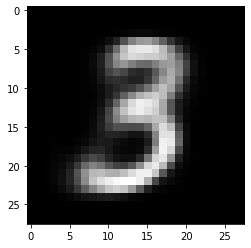

In [54]:
plt.imshow(decoder_output[0].numpy().reshape(28, 28), cmap = 'gray')
plt.show()

In [59]:
# Randomly create latent space points-
random_latent_space_points = np.array(
    [
     [4.2, -1.5, 4.5],
     [5.8, 3.6, 3.2]
    ]
)

In [60]:
# Use trained decoder to reconstruct images using random
# latent space representations-
decoder_output = model.decoder(random_latent_space_points)
decoder_output.shape

TensorShape([2, 28, 28, 1])

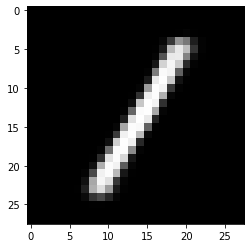

In [61]:
plt.imshow(decoder_output[0].numpy().reshape(28, 28), cmap = 'gray')
plt.show()

In [28]:
import plotly.express as px

In [29]:
# Visualize latent space of training images-
fig = px.scatter_3d(
    x = encoded_X_train[:, 0],
    y = encoded_X_train[:, 1], z = encoded_X_train[:, 2],
    color = np.argmax(y_train, axis = 1))
fig.show()

In [30]:
# Visualize latent space of validation images-
fig = px.scatter_3d(
    x = encoded_X_test[:, 0],
    y = encoded_X_test[:, 1], z = encoded_X_test[:, 2],
    color = np.argmax(y_test, axis = 1))
fig.show()

### Visualize Actual vs. Recreated MNIST Images
Using trained Autoencoder

In [31]:
recreated_image = model(X_train[:1, :])
recreated_image = recreated_image.numpy().reshape(28, 28)

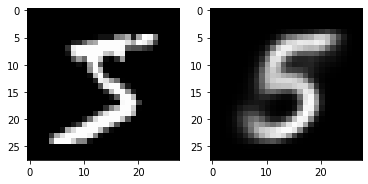

In [32]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[:1, :].reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

In [33]:
recreated_image = model(X_train[100:101, :])
recreated_image = recreated_image.numpy().reshape(28, 28)

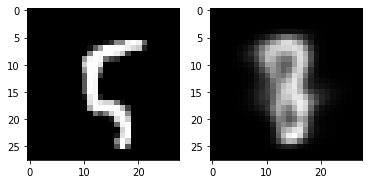

In [34]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[100:101, :].reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

In [35]:
recreated_image = model(X_train[58012:58013, :])
recreated_image = recreated_image.numpy().reshape(28, 28)

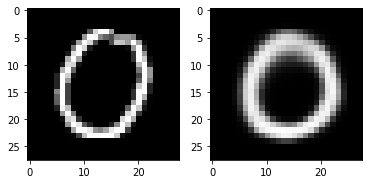

In [36]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[58012:58013, :].reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

In [37]:
recreated_image = model(X_train[45999:46000, :])
recreated_image = recreated_image.numpy().reshape(28, 28)

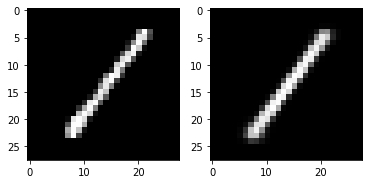

In [38]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[45999:46000, :].reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

In [39]:
recreated_image = model(X_train[39999:40000, :])
recreated_image = recreated_image.numpy().reshape(28, 28)

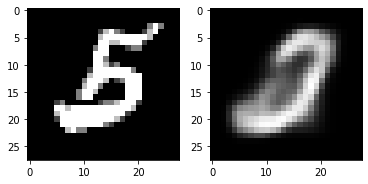

In [40]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[39999:40000, :].reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()